In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import scipy as sp
import inspect
import os
import sys
import time

import paragami

from copy import deepcopy

import bnpregcluster_runjingdev.regression_mixture_lib as gmm_lib

np.random.seed(42) # nothing special about this seed (we hope)!

In [2]:
reg_params = dict()
fit_dir = '/home/rgiordan/Documents/git_repos/BNP_sensitivity/RegressionClustering/jupyter/fits'
datafile = os.path.join(fit_dir, 'shrunken_transformed_gene_regression_df4_degree3_genes1000_inflate1.0.npz')
#datafile = os.path.join(fit_dir, 'shrunken_transformed_gene_regression_df4_degree3_genes10000_inflate1.0.npz')
with np.load(datafile) as infile:
    reg_params['y_info'] = infile['y_info']
    reg_params['beta_mean'] = infile['transformed_beta_mean']
    reg_params['beta_info'] = infile['transformed_beta_info']
    df = infile['df']
    degree = infile['degree']
    inflate_cov = infile.get('inflate_cov', 0)
    eb_shrunk = infile.get('eb_shrunk', False)
    
num_genes = reg_params['beta_mean'].shape[0]
obs_dim = reg_params['beta_mean'].shape[1]

num_components = 40

analysis_name = 'transformed_gene_regression_df{}_degree{}_genes{}_num_components{}_inflate{}_shrunk{}_fit'.format(
    df, degree, num_genes, num_components, inflate_cov, eb_shrunk)

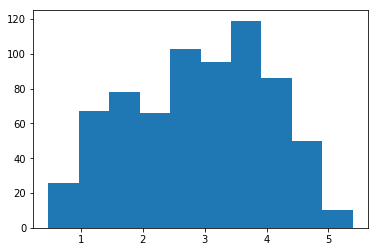

In [3]:
plt.hist(reg_params['y_info']);

In [4]:
prior_params = gmm_lib.get_base_prior_params(obs_dim, num_components)
prior_params['probs_alpha'][:] = 2.0

prior_params_pattern = gmm_lib.get_prior_params_pattern(obs_dim, num_components)
prior_params_pattern.validate_folded(prior_params)
gmm = gmm_lib.GMM(num_components, prior_params, reg_params)

In [5]:
print('Running k-means init.')
kmeans_params = \
    gmm_lib.kmeans_init(gmm.reg_params,
                        gmm.num_components, 50)
print('Done.')
init_gmm_params = dict()
init_gmm_params['centroids'] = kmeans_params['centroids']
init_gmm_params['stick_propn_mean'] = np.zeros(gmm.num_components - 1)
init_gmm_params['stick_propn_info'] = np.ones(gmm.num_components - 1)

init_x = gmm.gmm_params_pattern.flatten(init_gmm_params, free=True)

Running k-means init.
Done.


In [6]:
gmm.conditioned_obj.reset() # Reset the logging and iteration count.
gmm.conditioned_obj.set_print_every(1)

opt_time = time.time()
gmm_opt, init_x2 = gmm.optimize(init_x, gtol=1e-2)
opt_time = time.time() - opt_time

Iter 0: f = -8560.50283031
Iter 1: f = -8882.02143438
Iter 2: f = -9287.89194701
Iter 3: f = -9501.68675019
Iter 4: f = -9467.88345055
Iter 5: f = -9574.08012540
Iter 6: f = -9608.06179366
Iter 7: f = -9638.03018072
Iter 8: f = -9663.43628162
Iter 9: f = -9689.99649763
Iter 10: f = -9590.71709069
Iter 11: f = -9699.61534989
Iter 12: f = -9690.57204891
Iter 13: f = -9707.59227270
Iter 14: f = -9714.38191844
Iter 15: f = -9717.97823677
Iter 16: f = -9717.80765284
Iter 17: f = -9720.24548261
Iter 18: f = -9722.85619123
Iter 19: f = -9725.72910196
Iter 20: f = -9728.92874954
Iter 21: f = -9730.29476731
Iter 22: f = -9736.14278323
Iter 23: f = -9739.57850627
Iter 24: f = -9742.51110024
Iter 25: f = -9744.34780396
Iter 26: f = -9747.01738365
Iter 27: f = -9745.52614220
Iter 28: f = -9750.17537113
Iter 29: f = -9753.26879969
Iter 30: f = -9754.31480749
Iter 31: f = -9755.23941031
Iter 32: f = -9757.23827489
Iter 33: f = -9749.71282661
Iter 34: f = -9759.67845139
Iter 35: f = -9760.64532954
It

In [7]:
tic = time.time()
# Note that h_cond is the Hessian.
h_cond = gmm.update_preconditioner(init_x2)
opt_time += time.time() - tic

In [8]:
h_cond.shape, gmm.kl_obj.grad(init_x2).shape

((318, 318), (318,))

In [9]:
gmm.conditioned_obj.reset()
tic = time.time()
gmm_opt, gmm_opt_x = gmm.optimize_fully(
    init_x2, verbose=True, kl_hess=h_cond)
opt_time += time.time() - tic
print('Optimization time: {} seconds'.format(opt_time))

Iter 0: f = -9776.80091503
Preconditioned iteration 1
  Taking Newton step.
Iter 1: f = -9776.80091503
Iter 2: f = -9776.80088081
-3.42169023497263e-05
Iter 3: f = -9776.80088081
Shrinking step.
Iter 4: f = -9776.80089717
-1.7862728782347403e-05
Iter 5: f = -9776.80089717
Shrinking step.
Iter 6: f = -9776.80090529
-9.737716027302667e-06
Iter 7: f = -9776.80090529
Shrinking step.
Iter 8: f = -9776.80090989
-5.142264853930101e-06
Iter 9: f = -9776.80090989
Shrinking step.
Iter 10: f = -9776.80091238
-2.6480975066078827e-06
Iter 11: f = -9776.80091238
Shrinking step.
Iter 12: f = -9776.80091368
-1.3443441275740042e-06
Iter 13: f = -9776.80091368
Shrinking step.
Iter 14: f = -9776.80091435
-6.773734639864415e-07
Iter 15: f = -9776.80091435
Shrinking step.
Iter 16: f = -9776.80091469
-3.4000004234258085e-07
Iter 17: f = -9776.80091469
Shrinking step.
Iter 18: f = -9776.80091486
-1.7033198673743755e-07
Iter 19: f = -9776.80091486
Shrinking step.
Iter 20: f = -9776.80091494
-8.524693839717656

In [11]:
# Use the script initial_fit.py to save results in a standard format.

# opt_gmm_params = gmm.gmm_params_pattern.fold(gmm_opt_x, free=True)

# save_dict = deepcopy(gmm_opt)
# save_dict['df'] = df
# save_dict['degree'] = degree
# save_dict['datafile'] = datafile
# save_dict['num_components'] = num_components
# save_dict['gmm_params_pattern_json'] = \
#     gmm.gmm_params_pattern.to_json()
# save_dict['opt_gmm_params_flat'] = \
#     gmm.gmm_params_pattern.flatten(opt_gmm_params, free=False)
# save_dict['prior_params_pattern_json'] = \
#     prior_params_pattern.to_json()
# save_dict['prior_params_flat'] = \
#     prior_params_pattern.flatten(prior_params, free=False)

# save_dict['opt_time'] = opt_time

# outfile = os.path.join(fit_dir, '{}.npz'.format(analysis_name))
# print('Saving to {}'.format(outfile))

# np.savez_compressed(file=outfile, **save_dict)

Saving to /home/rgiordan/Documents/git_repos/BNP_sensitivity/RegressionClustering/jupyter/fits/transformed_gene_regression_df4_degree3_genes700_num_components40_inflate1.0_shrunkTrue_fit.npz


In [12]:
print(opt_gmm_params.keys())
e_z = gmm.get_e_z(opt_gmm_params)
print(np.sort(np.sum(e_z, axis=0)))

odict_keys(['centroids', 'stick_propn_mean', 'stick_propn_info'])
[7.68106404e-03 1.28498261e-02 2.00260114e-02 2.15061082e-02
 3.60846056e-02 6.93480055e-02 2.01223993e-01 2.46696934e-01
 3.10897148e-01 7.09535393e-01 1.02015494e+00 1.03153588e+00
 1.03159472e+00 1.11376351e+00 1.13943255e+00 1.18011594e+00
 1.71603417e+00 1.93355321e+00 1.97218773e+00 1.97716896e+00
 1.99623597e+00 2.56488516e+00 4.14009769e+00 5.93766528e+00
 6.00775339e+00 6.03177427e+00 7.11227104e+00 7.60439585e+00
 1.06414544e+01 1.27477645e+01 1.40133334e+01 1.81247259e+01
 2.96809931e+01 3.57733978e+01 3.59740882e+01 3.91928413e+01
 6.41656817e+01 7.86295379e+01 1.48279081e+02 1.55630631e+02]


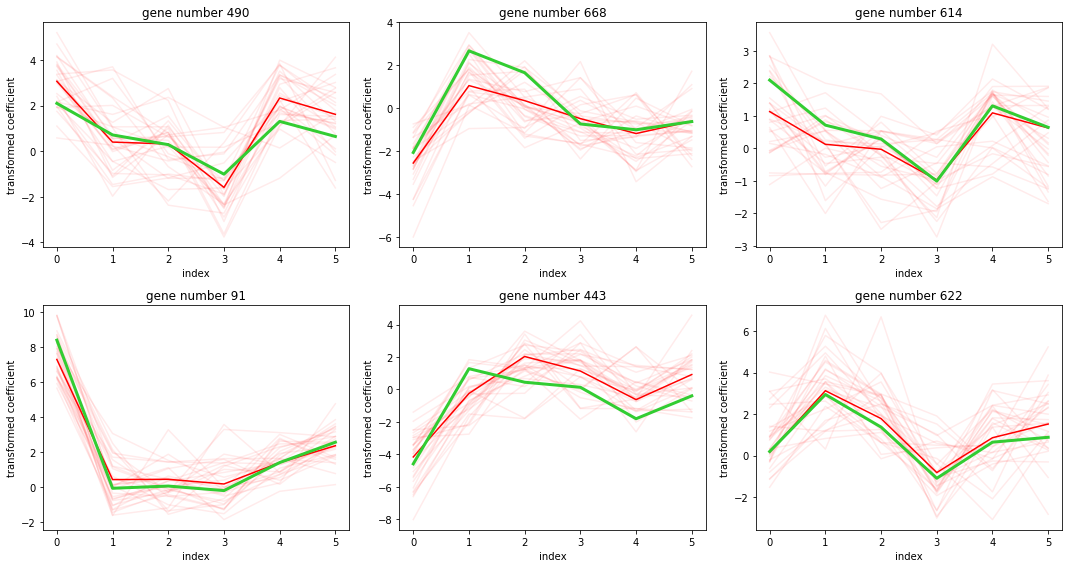

In [13]:
# Sanity check with a figure

f, axarr = plt.subplots(2, 3, figsize=(15,8))

plot_inds = np.random.choice(gmm.num_obs, 6, replace=False)
for i in range(6):
    n = plot_inds[i]
    this_plot = axarr[int(np.floor(i / 3)), i % 3] 
    this_plot.plot(gmm.reg_params['beta_mean'][n, :], color = 'red');
    this_plot.set_ylabel('transformed coefficient')
    this_plot.set_xlabel('index')
    this_plot.set_title('gene number {}'.format(n))

    # draw from the variational distribution to plot uncertainties
    for j in range(30): 
        transformed_beta_draw = np.random.multivariate_normal(
            gmm.reg_params['beta_mean'][n, :], \
             np.linalg.inv(gmm.reg_params['beta_info'][n, :, :]))

        this_plot.plot(
            transformed_beta_draw, color = 'red', alpha = 0.08);

    k = np.argmax(e_z[n, :])
    this_plot.plot(opt_gmm_params['centroids'][k, :], color = 'limegreen', linewidth=3);

f.tight_layout()

There are 13 small clusters


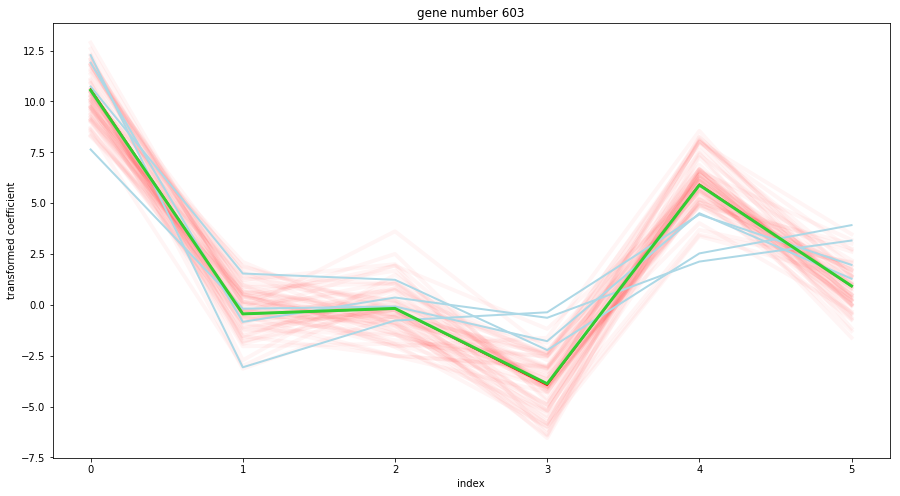

In [14]:
# for i in range(num_components):
#     print('{:0.5}\t{:0.5}'.format(np.sum(e_z, axis=0)[i], np.std(e_z, axis=0)[i]))
loglik_obs_by_nk = gmm_lib.get_loglik_obs_by_nk(opt_gmm_params, gmm.reg_params)

small_cluster_size = 1.1

z_sum = np.sum(e_z, axis=0)
small_clusters = np.squeeze(np.argwhere(z_sum < small_cluster_size))
small_clusters
obs_k = np.full(gmm.num_obs, int(-1))
for n in range(gmm.num_obs):
    obs_k[n] = np.argmax(e_z[n, :])

# Plot one of the small components
print('There are', len(small_clusters), 'small clusters')

k_small = 0
n_in_cluster = np.argwhere(obs_k == small_clusters[k_small])

if len(n_in_cluster) > 0:
    n = int(n_in_cluster[0])

    # Get the top alternative components
    top_components = np.argsort(-1 * loglik_obs_by_nk[n, :])[0:5]

    f, axarr = plt.subplots(1, figsize=(15,8))
    this_plot = axarr
    this_plot.plot(gmm.reg_params['beta_mean'][n, :], color = 'red');
    this_plot.set_ylabel('transformed coefficient')
    this_plot.set_xlabel('index')
    this_plot.set_title('gene number {}'.format(n))

    # draw from the variational distribution to plot uncertainties
    for j in range(60): 
        transformed_beta_draw = np.random.multivariate_normal(
            gmm.reg_params['beta_mean'][n, :], \
             np.linalg.inv(gmm.reg_params['beta_info'][n, :, :]))
        this_plot.plot(
            transformed_beta_draw, color = 'red', alpha = 0.04, linewidth=4);

    for k in top_components:
        if k != k_small:
            this_plot.plot(opt_gmm_params['centroids'][k, :],
                           color = 'lightblue', linewidth=2);

    k = np.argmax(e_z[n, :])
    this_plot.plot(opt_gmm_params['centroids'][k, :], color = 'limegreen', linewidth=3);
else:
    print('No points belong mostly to this cluster ({}).'.format(small_clusters[k_small]))
